# Part B: News Article Classification

In [77]:
# Importing Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from scipy.sparse import hstack

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import RandomizedSearchCV


# 1. Data Collection and Preprocessing

#### 1a. Collect a dataset of labeled news articles (sports, politics, technology etc).

In [80]:
# Loading CSV file into a DataFrame
news_df = pd.read_csv('data_news.csv')

In [81]:
# Displaying the first 5 rows
print(news_df.head())

   category                                           headline  \
0  WELLNESS              143 Miles in 35 Days: Lessons Learned   
1  WELLNESS       Talking to Yourself: Crazy or Crazy Helpful?   
2  WELLNESS  Crenezumab: Trial Will Gauge Whether Alzheimer...   
3  WELLNESS                     Oh, What a Difference She Made   
4  WELLNESS                                   Green Superfoods   

                                               links  \
0  https://www.huffingtonpost.com/entry/running-l...   
1  https://www.huffingtonpost.com/entry/talking-t...   
2  https://www.huffingtonpost.com/entry/crenezuma...   
3  https://www.huffingtonpost.com/entry/meaningfu...   
4  https://www.huffingtonpost.com/entry/green-sup...   

                                   short_description  \
0  Resting is part of training. I've confirmed wh...   
1  Think of talking to yourself as a tool to coac...   
2  The clock is ticking for the United States to ...   
3  If you want to be busy, keep trying to 

In [82]:
# Displaying number of rows and columns present in the dataframe
news_df.shape

(50000, 5)

#### 1b. Handle missing data, if any, and ensure the text is ready for feature extraction.

In [84]:
# Checking if there are any null values or missing values present in the dataframe
news_df.isnull().sum()

category                0
headline                0
links                   0
short_description       0
keywords             2668
dtype: int64

#### Obervations:
Keyword Feature has 2668 null values in it.

In [86]:
# Filling the null values with the mode of the column
news_df['keywords'] = news_df['keywords'].fillna(news_df['keywords'].mode()[0])

#### 1c. Clean and preprocess the text data.

#### a. Removing punctuation, special characters and converting text to lowercase.

In [89]:
# Converting all the headline to lowercase
news_df['headline']= news_df['headline'].str.lower()

In [90]:
# Converting all the short_description to lowercase
news_df['short_description']= news_df['short_description'].str.lower()

In [91]:
# Converting all the keywords to lowercase
news_df['keywords']= news_df['keywords'].str.lower()

In [92]:
# Creating a custom function for removing punctuation and special_characters for columns with text data type
def remove_punctuation_special_characters(input_text):
    # Removing special characters and punctuation from the input_text column
    output_review=re.sub(r'[^a-z\s]','',input_text)
    return output_review

#### b. Tokenization of text (splitting text into words).


In [94]:
# Creating function to columns with text data type
def tokenize_text(input_text):
    return word_tokenize(input_text)

#### c. Removing extra spaces and stop words from reviews

In [96]:
# Removing "not" word from stopword list. As it might have impact on text data type column
stop_words = set(stopwords.words('english'))
stop_words.discard('not')
print("not" in stop_words)

False


In [97]:
# Creating function to remove stopwords and extra spaces from columns with text data type
def remove_extra_spaces_and_stopwords(input_text):

    # Removing any extra spaces in each word of the input_text
    tokens = [token.strip() for token in input_text]

    # Removing stopwords from input_text
    return [word for word in input_text if word not in stop_words]


#### d. Performing Lemmatization

In [99]:
# Creating function to lemmatize tokenised text
def lemmatizer_tokens(input_text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in input_text]


In [100]:
# Creating function to join cleaned text into a single string
def join_tokens(input_text):
    return ' '.join(input_text)

In [101]:
# Applying remove_punctuation_special_characters function to text columns
news_df['headline']= news_df['headline'].apply(remove_punctuation_special_characters)
news_df['short_description']= news_df['short_description'].apply(remove_punctuation_special_characters)

In [102]:
# Creating remove_hyphen function
def remove_hyphen(input_text):
    # Removing hyphens and split compound words
    input_text = re.sub(r'[-]', ' ', input_text)
    return input_text

In [103]:
# Applying remove_hyphen function to text columns
news_df['keywords']= news_df['keywords'].apply(remove_hyphen)

In [104]:
# Applying remove_punctuation_special_characters function to text columns
news_df['keywords']= news_df['keywords'].apply(remove_punctuation_special_characters)

In [105]:
# Applying tokenize_text functions to text columns
news_df['headline']= news_df['headline'].apply(tokenize_text)
news_df['short_description']= news_df['short_description'].apply(tokenize_text)
news_df['keywords']= news_df['keywords'].apply(tokenize_text)

In [106]:
# Applying remove_extra_spaces_and_stopwords functions to text columns
news_df['headline']= news_df['headline'].apply(remove_extra_spaces_and_stopwords)
news_df['short_description']= news_df['short_description'].apply(remove_extra_spaces_and_stopwords)
news_df['keywords']= news_df['keywords'].apply(remove_extra_spaces_and_stopwords)

In [107]:
# Applying the lemmatize_tokens functions to text columns
news_df['headline']= news_df['headline'].apply(lemmatizer_tokens)
news_df['short_description']= news_df['short_description'].apply(lemmatizer_tokens)
news_df['keywords']= news_df['keywords'].apply(lemmatizer_tokens)

In [108]:
# Applying join_tokens functions to text columns
news_df['headline']= news_df['headline'].apply(join_tokens)
news_df['short_description']= news_df['short_description'].apply(join_tokens)
news_df['keywords']= news_df['keywords'].apply(join_tokens)

In [109]:
# Displaying the first 5 rows
news_df.head()

,category,headline,links,short_description,keywords
0,WELLNESS,mile day lesson learned,https://www.huffingtonpost.com/entry/running-l...,resting part training ive confirmed sort alrea...,running lesson
1,WELLNESS,talking crazy crazy helpful,https://www.huffingtonpost.com/entry/talking-t...,think talking tool coach challenge narrate exp...,talking crazy
2,WELLNESS,crenezumab trial gauge whether alzheimers drug...,https://www.huffingtonpost.com/entry/crenezuma...,clock ticking united state find cure team work...,crenezumab alzheimers disease drug
3,WELLNESS,oh difference made,https://www.huffingtonpost.com/entry/meaningfu...,want busy keep trying perfect want happy focus...,meaningful life
4,WELLNESS,green superfoods,https://www.huffingtonpost.com/entry/green-sup...,first bad news soda bread corned beef beer not...,green superfoods


# 2. Feature Extraction

#### 1. Use methods like TF-IDF, word embeddings (e.g., Word2Vec, GloVe), or bag-of-words to convert text data into numerical features.

In [112]:
# Creating a new column in the DataFrame to store the length of each headline by counting words in each headline
news_df['headline_word_count'] = news_df['headline'].apply(lambda x: len(x.split()))

In [113]:
# Creating a new column in the DataFrame to store the length of each headline by counting words in each short description
news_df['short_decription_word_count'] = news_df['short_description'].apply(lambda x: len(x.split()))

In [114]:
# Calculating the total number of characters in headline column
news_df['headline_char_count'] = news_df['headline'].str.len()

In [115]:
# Calculating the total number of characters in short_description column
news_df['short_description_char_count'] = news_df['short_description'].str.len()

In [116]:
# Avoiding division by zero by replacing zero word counts with NaN
news_df['headline_avg_word_length'] = news_df.apply(lambda row: row['headline_char_count'] / row['headline_word_count'] if row['headline_word_count'] > 0 else 0, axis=1)

In [117]:
# Avoiding division by zero by replacing zero word counts with NaN
news_df['short_description_avg_word_length'] = news_df.apply(lambda row: row['short_description_char_count'] / row['short_decription_word_count'] if row['short_decription_word_count'] > 0 else 0, axis=1)

In [121]:
news_df.head()

,category,headline,links,short_description,keywords,headline_word_count,short_decription_word_count,headline_char_count,short_description_char_count,headline_avg_word_length,short_description_avg_word_length
0,WELLNESS,mile day lesson learned,https://www.huffingtonpost.com/entry/running-l...,resting part training ive confirmed sort alrea...,running lesson,4,33,23,203,5.750000,6.151515
1,WELLNESS,talking crazy crazy helpful,https://www.huffingtonpost.com/entry/talking-t...,think talking tool coach challenge narrate exp...,talking crazy,4,14,27,95,6.750000,6.785714
2,WELLNESS,crenezumab trial gauge whether alzheimers drug...,https://www.huffingtonpost.com/entry/crenezuma...,clock ticking united state find cure team work...,crenezumab alzheimers disease drug,9,12,67,75,7.444444,6.250000
3,WELLNESS,oh difference made,https://www.huffingtonpost.com/entry/meaningfu...,want busy keep trying perfect want happy focus...,meaningful life,3,10,18,64,6.000000,6.400000
4,WELLNESS,green superfoods,https://www.huffingtonpost.com/entry/green-sup...,first bad news soda bread corned beef beer not...,green superfoods,2,16,16,91,8.000000,5.687500


#### 2. Feature extraction using techniques like TF-IDF, Word2Vec, or embeddings.

In [123]:
# Concatenating the headline, short_description and keywords columns into a single dataframe
news_df['combined_text'] = news_df['headline'] + ' ' + news_df['short_description'] + ' ' + news_df['keywords']

In [124]:
# Initializing TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000, min_df=5, max_df=0.95)

# Fitting and transforming combined_text column
X_tfidf = vectorizer.fit_transform(news_df['combined_text'])

In [125]:
# Converting X_tfidf dataFrame for better readability
X_tfidf_array = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
print(X_tfidf_array)

       aaron   ab  abandon  abandoned  abbas  abbey  abbott  abby  abc  \
0        0.0  0.0      0.0        0.0    0.0    0.0     0.0   0.0  0.0   
1        0.0  0.0      0.0        0.0    0.0    0.0     0.0   0.0  0.0   
2        0.0  0.0      0.0        0.0    0.0    0.0     0.0   0.0  0.0   
3        0.0  0.0      0.0        0.0    0.0    0.0     0.0   0.0  0.0   
4        0.0  0.0      0.0        0.0    0.0    0.0     0.0   0.0  0.0   
...      ...  ...      ...        ...    ...    ...     ...   ...  ...   
49995    0.0  0.0      0.0        0.0    0.0    0.0     0.0   0.0  0.0   
49996    0.0  0.0      0.0        0.0    0.0    0.0     0.0   0.0  0.0   
49997    0.0  0.0      0.0        0.0    0.0    0.0     0.0   0.0  0.0   
49998    0.0  0.0      0.0        0.0    0.0    0.0     0.0   0.0  0.0   
49999    0.0  0.0      0.0        0.0    0.0    0.0     0.0   0.0  0.0   

       abdominal  ...  zinke  zip  zoe  zombie  zone  zoo  zooey  zucchini  \
0            0.0  ...    0.0  0.0

#### 3. Perform exploratory data analysis (EDA) to understand the distribution of different categories.

In [127]:
# Checking if the dataset is balanced or not
category_count = news_df['category'].value_counts()

# Printing the results
print(category_count)

category
WELLNESS          5000
POLITICS          5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
WORLD NEWS        5000
BUSINESS          5000
SPORTS            5000
Name: count, dtype: int64


#### Observation:
Dataset is a balanced dataset as all 10 categories have equal number of records in the dataset.

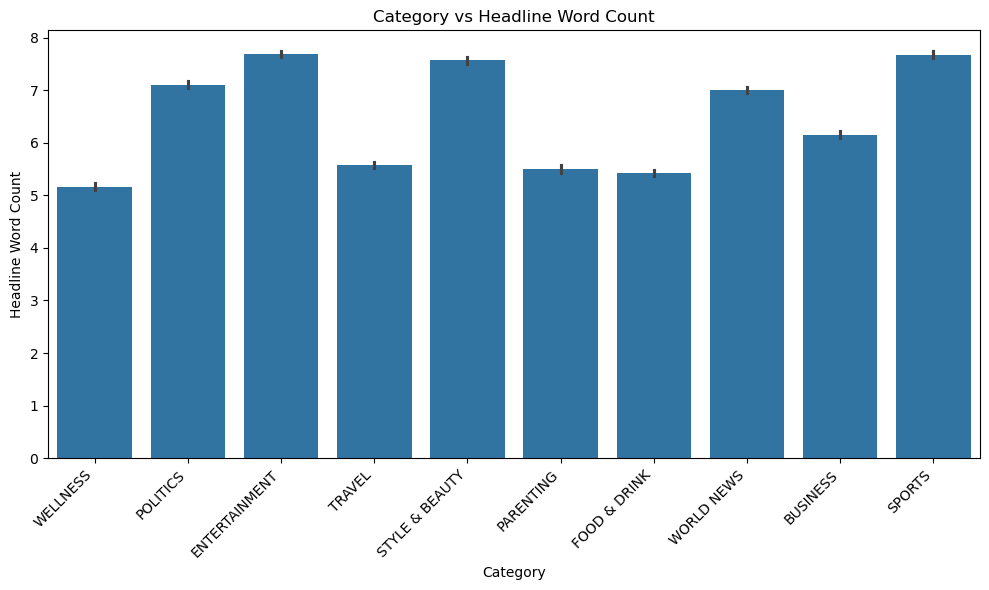

In [129]:
# Displaying bar plot for category vs headline_word_count feature
plt.figure(figsize=(10, 6))
sns.barplot(x='category', y='headline_word_count', data=news_df)
plt.title('Category vs Headline Word Count')
plt.xlabel('Category')
plt.ylabel('Headline Word Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

#### Observation:
1. Entertainment category has highest value for headline word count feature.
2. Style & Beauty category and Sports category have next highest value for headline word count feature.
3. Wellness category has lowest value for headline word count feature.
4. Travel category, Parenting category and Food and Drink category have next lowest value for headline word count feature.

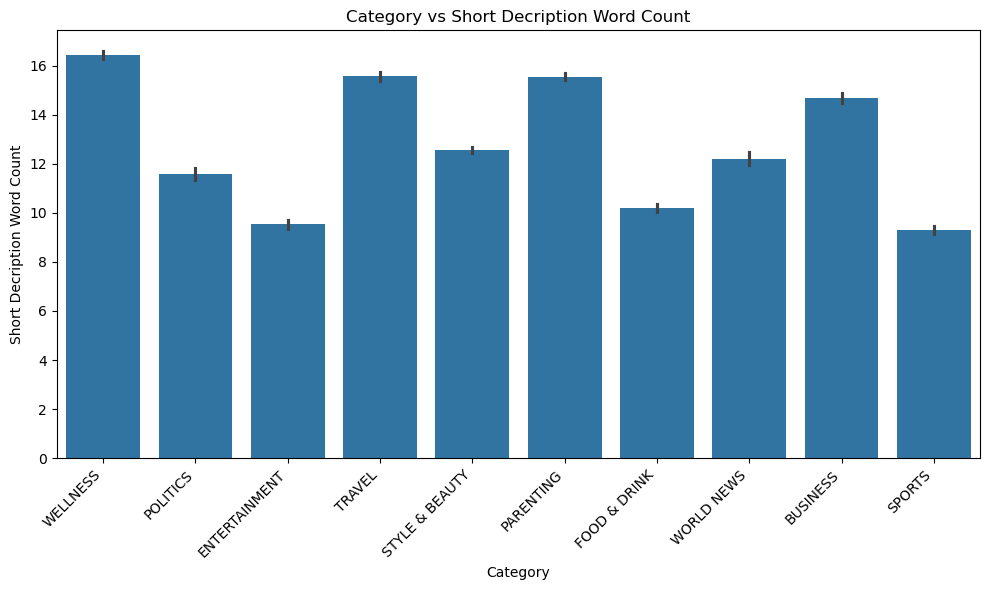

In [131]:
# Displaying bar plot for category vs short_decription_word_count feature
plt.figure(figsize=(10, 6))
sns.barplot(x='category', y='short_decription_word_count', data=news_df)
plt.title('Category vs Short Decription Word Count')
plt.xlabel('Category')
plt.ylabel('Short Decription Word Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

#### Observation:
1. Wellness category has the highest value for short description word count feature.
2. Travel category and Parent category have next highest value for short description word count feature.
3. Sports category has lowest value for short description word count feature.
4. Entertainment category and Food and Drink category have next lowest value for short description word count feature.

# 3. Model Development and Training

#### 3a. Build classification models using algorithms like Logistic Regression, Naive Bayes, Support Vector Machines (SVM). Train the models on the preprocessed text data.

In [135]:
# Initializing LabelEncoder
label_encoder = LabelEncoder()

# Fitting and transforming the sentiment column
news_df['category'] = label_encoder.fit_transform(news_df['category'])

news_df.head()

,category,headline,links,short_description,keywords,headline_word_count,short_decription_word_count,headline_char_count,short_description_char_count,headline_avg_word_length,short_description_avg_word_length,combined_text
0,8,mile day lesson learned,https://www.huffingtonpost.com/entry/running-l...,resting part training ive confirmed sort alrea...,running lesson,4,33,23,203,5.750000,6.151515,mile day lesson learned resting part training ...
1,8,talking crazy crazy helpful,https://www.huffingtonpost.com/entry/talking-t...,think talking tool coach challenge narrate exp...,talking crazy,4,14,27,95,6.750000,6.785714,talking crazy crazy helpful think talking tool...
2,8,crenezumab trial gauge whether alzheimers drug...,https://www.huffingtonpost.com/entry/crenezuma...,clock ticking united state find cure team work...,crenezumab alzheimers disease drug,9,12,67,75,7.444444,6.250000,crenezumab trial gauge whether alzheimers drug...
3,8,oh difference made,https://www.huffingtonpost.com/entry/meaningfu...,want busy keep trying perfect want happy focus...,meaningful life,3,10,18,64,6.000000,6.400000,oh difference made want busy keep trying perfe...
4,8,green superfoods,https://www.huffingtonpost.com/entry/green-sup...,first bad news soda bread corned beef beer not...,green superfoods,2,16,16,91,8.000000,5.687500,green superfoods first bad news soda bread cor...


In [136]:
# Extracting numerical features and target variable
numerical_features = news_df[['headline_word_count','short_decription_word_count','headline_char_count','short_description_char_count',
                              'headline_avg_word_length','short_description_avg_word_length']].values
y = news_df['category'].values

# Combine TF-IDF features with numerical features
X_final = hstack([X_tfidf, numerical_features])


In [137]:
# Splitting Dataset into Train Set and Test Set: (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [138]:
print(X_train.shape)
print(X_test.shape)

(40000, 10006)
(10000, 10006)


In [139]:
# Displaying 5 rows with 30 columns from X_train
X_train_display = X_train[:5, :10].toarray()
print(X_train_display)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [140]:
# Displaying 5 rows with 30 columns from X_test
X_test_display = X_test[:5, :10].toarray()
print(X_test_display)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# 1. Logistic Regression

In [142]:
# Building Logistic Regression Model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

C:\Users\meena\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [143]:
# Prediction on X_test using Logistic Regression Model
y_pred_logreg = logreg_model.predict(X_test)

In [144]:
# Evaluating Logistic Regression Model

print("Logistic Regression Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg)}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Evaluation:
Accuracy: 0.2388

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.13      0.16       955
           1       0.24      0.17      0.20       985
           2       0.27      0.45      0.34      1021
           3       0.25      0.26      0.25      1030
           4       0.23      0.09      0.13      1034
           5       0.23      0.30      0.26       995
           6       0.28      0.40      0.33       986
           7       0.26      0.03      0.06      1008
           8       0.21      0.28      0.24      1009
           9       0.19      0.27      0.23       977

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.22     10000
weighted avg       0.24      0.24      0.22     10000



#### Observation:
With Default values, Logistic Regression Model is performing poorly on test data with an accuracy of 23.88%. Performing hyperparameter tuning to get better accuracy.

#### 3b. Tuning hyperparameters as necessary. Use cross-validation to ensure robust evaluation of model performance.

### Model Tuning: Experiment with different models and tune hyperparameters to optimize performance.

In [147]:
# Parameter list
logreg_param_grid = {'C': [0.01, 1, 10],
                    'penalty': ['l1', 'l2'],
                    'solver': ['liblinear'],
                    'max_iter': [100, 200, 300]}

In [148]:
# Building Logistic Regression model
logreg = LogisticRegression()

# Setting up RandomizedSearchCV
logreg_random_search = RandomizedSearchCV(estimator=logreg, param_distributions=logreg_param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)

# Fitting the model using RandomizedSearchCV
logreg_random_search.fit(X_train, y_train)

# Printing the best hyperparameters and best score
print("Best Parameters:", logreg_random_search.best_params_)
print("Best Accuracy:", logreg_random_search.best_score_)

Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 200, 'C': 10}
Best Accuracy: 0.8286


#### Observation:
After hyperparameter tuning for Logistic Regression model, accuracy has increased from 23.88% to 82.86%. We can consider this model during model evaluation as the accuracy value is highest among all other models. See below for reference.

# 2. Random Forest

In [150]:
# Building Random Forest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [151]:
# Prediction on X_test using Random Forest Model
y_pred_rf = rf_model.predict(X_test)

In [152]:
# Evaluating Random Forest Model

print("Random Forest Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Evaluation:
Accuracy: 0.7577

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       955
           1       0.68      0.73      0.70       985
           2       0.74      0.80      0.77      1021
           3       0.78      0.80      0.79      1030
           4       0.79      0.61      0.69      1034
           5       0.89      0.88      0.88       995
           6       0.82      0.82      0.82       986
           7       0.77      0.70      0.73      1008
           8       0.63      0.75      0.68      1009
           9       0.72      0.70      0.71       977

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



#### Observations:
With Default values, Random Forest Model is performing well on test data with an accuracy of 75.77%. Performing hyperparameter tuning to get better accuracy.

### Model Tuning: Experiment with different models and tune hyperparameters to optimize performance.

In [154]:
# Parameter list
rf_param_grid = { 'n_estimators': [100, 200, 300],
                  'max_depth': [10, 20, 30],
                  'criterion': ['gini', 'entropy']}

In [155]:
# Initializing Random Forest model
rf = RandomForestClassifier()

# Setting up RandomizedSearchCV
rf_random_search= RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)

# Fitting the model using RandomizedSearchCV
rf_random_search.fit(X_train, y_train)

# Printing the best hyperparameters and best score
print("Best Parameters:", rf_random_search.best_params_)
print("Best Accuracy:", rf_random_search.best_score_)

Best Parameters: {'n_estimators': 300, 'max_depth': 30, 'criterion': 'gini'}
Best Accuracy: 0.6933499999999999


#### Observation:
After hyperparameter tuning for Random Forest model, accuracy has decreased from 75.77% to 69.33%. Since the accuracy value is less than logistic regression model, not considering this model during model evaluation.

# 3. Support Vector Machine (SVM)

In [157]:
# Building SVM Model
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [158]:
# Prediction on X_test using SVM Model
y_pred_svm = svm_model.predict(X_test)

In [159]:
# Evaluating SVM Model

print("SVM Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Evaluation:
Accuracy: 0.2388

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.16      0.18       955
           1       0.34      0.23      0.27       985
           2       0.32      0.31      0.32      1021
           3       0.21      0.26      0.23      1030
           4       0.32      0.01      0.03      1034
           5       0.21      0.17      0.19       995
           6       0.23      0.59      0.33       986
           7       0.18      0.02      0.04      1008
           8       0.22      0.39      0.28      1009
           9       0.24      0.25      0.24       977

    accuracy                           0.24     10000
   macro avg       0.25      0.24      0.21     10000
weighted avg       0.25      0.24      0.21     10000



#### Observation:
With Default values, SVM Model is performing poorly on test data with an accuracy of 23.88%. So, not considering this model for model evaluation.

# 4. Model Evaluation

#### Evaluate the model’s performance using appropriate metrics.

Among all the models, Logistic regression is giving highest accuracy. So considering this model for evaluating the model performance.

#### Logistic Regression

In [165]:
# Building Logistic Regression Model
logreg_model = LogisticRegression(solver='liblinear', penalty= 'l2', max_iter= 200, C= 10)
logreg_model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=200, solver='liblinear')

In [167]:
# Prediction on X_test using Logistic Regression Model
y_pred_logreg = logreg_model.predict(X_test)

In [169]:
# Evaluating Logistic Regression Model

print("Logistic Regression Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg)}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Evaluation:
Accuracy: 0.8348

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       955
           1       0.85      0.82      0.83       985
           2       0.89      0.88      0.88      1021
           3       0.81      0.79      0.80      1030
           4       0.81      0.76      0.78      1034
           5       0.90      0.93      0.92       995
           6       0.89      0.89      0.89       986
           7       0.84      0.84      0.84      1008
           8       0.78      0.77      0.77      1009
           9       0.82      0.83      0.82       977

    accuracy                           0.83     10000
   macro avg       0.83      0.84      0.83     10000
weighted avg       0.83      0.83      0.83     10000



#### Observation:
1. Accuracy is improved from 82.86% to 83.48% on unseen data when hyperparameter tuned values are considered. So we can consider this model for predicting catergories of a news article.
2. We have high precision and recall for all the categories. This indicates that the model is able to correctly predict the categories for the given news article.

#### Visualisation of Logistic Regression Model

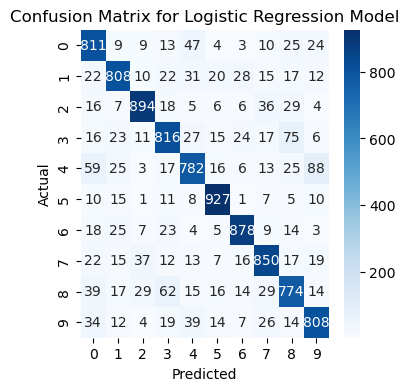

In [175]:
import numpy as np

# Generating confusion matrix
lr_confusion_matrix = confusion_matrix(y_test, y_pred_logreg,labels=np.arange(10))

# Plotting confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(lr_confusion_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=np.arange(10), yticklabels=np.arange(10))

# Setting labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression Model')

# Displaying plot
plt.show()

#### Observation:
1. All Diagonal elements of the confusion matrix have high values indicating that the model is correctly classifying instances for all the classes. 
2. We have low values in all off diagonal matrix indicating that the misclassification of the classes is less by the model.
3. Hence we can prefer Logistic Regression Model for predicting categories for the unseen or future news article.

In [180]:
# Creating pre processing text function
def preprocessing_text(new_headline, new_short_description,new_keywords):
    # Convertion to lowercase
    new_headline = new_headline.lower()
    new_short_description = new_short_description.lower()
    new_keywords = new_keywords.lower()

    # Removing hyphens and split compound words
    new_keywords = re.sub(r'[-]', ' ', new_keywords)

    # Removing special characters and punctuation
    new_headline = re.sub(r'[^a-z\s]', '', new_headline) 
    new_short_description = re.sub(r'[^a-z\s]', '', new_short_description)    
    new_keywords = re.sub(r'[^a-z\s]', '', new_keywords)
    
    # Applying tokenisation
    new_headline = word_tokenize(new_headline)
    new_short_description = word_tokenize(new_short_description)
    new_keywords = word_tokenize(new_keywords)

    # Removing any extra spaces in each word of the new_review
    new_headline = [word.strip() for word in new_headline]
    new_short_description = [word.strip() for word in new_short_description]
    new_keywords = [word.strip() for word in new_keywords]

    # Removing stopwords from new_review
    new_headline = [word for word in new_headline if word not in stop_words]
    new_short_description = [word for word in new_short_description if word not in stop_words]
    new_keywords = [word for word in new_keywords if word not in stop_words]

    # Applying Lemmatization
    lemmatizer = WordNetLemmatizer()
    new_headline = [lemmatizer.lemmatize(word) for word in new_headline]
    new_short_description = [lemmatizer.lemmatize(word) for word in new_short_description]
    new_keywords = [lemmatizer.lemmatize(word) for word in new_keywords]

    # Joining input review
    new_headline = ' '.join(new_headline)
    new_short_description = ' '.join(new_short_description)
    new_keywords = ' '.join(new_keywords) 

    pre_processed_news = new_headline + ' ' + new_short_description + ' ' + new_keywords

    return pre_processed_news


In [182]:
# Creating predict_sentiment function
def predict_sentiment(input_new_headline, input_new_short_description, input_new_keywords):
    # Preprocess the review (extracting the first review from the list)
    preprocessed_news = preprocessing_text(input_new_headline, input_new_short_description, input_new_keywords)

    headline_word_count = len(input_new_headline.split())
    short_decription_word_count = len(input_new_short_description.split())
   
    headline_char_count= len(input_new_headline)
    short_description_char_count= len(input_new_short_description)
    
    headline_avg_word_length = headline_char_count / headline_word_count if headline_word_count > 0 else 0
    short_description_avg_word_length = short_description_char_count / short_decription_word_count if short_decription_word_count > 0 else 0
   
    # Creating dataFrame for the news article with the additional features
    new_data = pd.DataFrame({
        'preprocessed_news': [preprocessed_news],
        'headline_word_count': [headline_word_count],
        'short_decription_word_count': [short_decription_word_count],
        'headline_char_count' : [headline_char_count],
        'short_description_char_count':[short_description_char_count],
        'headline_avg_word_length': [headline_avg_word_length],
        'short_description_avg_word_length': [short_description_avg_word_length]
    })

    # Transforming news article using the vectorizer
    news_tfidf = vectorizer.transform(new_data['preprocessed_news'])

    # Combining transformed TF-IDF features with the additional features
    additional_features = new_data[['headline_word_count','short_decription_word_count','headline_char_count','short_description_char_count',
                                    'headline_avg_word_length','short_description_avg_word_length']].values
    combined_features = hstack([news_tfidf, additional_features])

    # Predicting sentiment using the logreg_model
    predictions = logreg_model.predict(combined_features)

    # Label encoder gives labelling based on alphabetical order, so matching prediction with category label
    if predictions==0:
        print("News article belongs to Business Category")
    elif predictions==1:
        print("News article belongs to Food and Drink Category")
    elif predictions==2:
        print("News article belongs to Entertainment Category")    
    elif predictions==3:
        print("News article belongs to Sports Category")
    elif predictions==4:
        print("News article belongs to Parenting Category")
    elif predictions==5:
        print("News article belongs to Style and Beauty Category")
    elif predictions==6:
        print("News article belongs to Politics Category")
    elif predictions==7:
        print("News article belongs to Travel Category")
    elif predictions==8:
        print("News article belongs to Wellness Category")
    else:
        print("News article belongs to World News Category")


#### Sample news article belonging to Business Category 

In [198]:
# Taking news article from user
user_new_headline=input("Enter the headline\n")
user_new_short_description=input("Enter the short description\n")
user_new_keywords=input("Enter the keywords\n")

# Calling predict_sentiment function
predict_sentiment(user_new_headline, user_new_short_description, user_new_keywords)

Enter the headline
 US Securities Regulator Seeks India's Help in Fraud Probe Against Gautam Adani"
Enter the short description
 US prosecutors charge Gautam Adani with involvement in a plan to pay over $250 million in bribes to Indian officials.
Enter the keywords
 Gautam Adani, US Securities Regulator, fraud probe, bribery, India


News article belongs to Business Category


#### Sample news article belonging to World News Category 

In [200]:
# Taking news article from user  
user_new_headline=input("Enter the headline\n")
user_new_short_description=input("Enter the short description\n")
user_new_keywords=input("Enter the keywords\n")

# Calling predict_sentiment function
predict_sentiment(user_new_headline, user_new_short_description, user_new_keywords)

Enter the headline
 Pope Francis' Health Declines Amid Succession Concerns"
Enter the short description
 ope Francis' worsening health raises concerns over the papal succession.
Enter the keywords
 Pope Francis, health, papal succession, Vatican, Catholic Church


News article belongs to World News Category


#### Sample news article belonging to Sports Category 

In [202]:
# Taking news article from user
user_new_headline=input("Enter the headline\n")
user_new_short_description=input("Enter the short description\n")
user_new_keywords=input("Enter the keywords\n")

# Calling predict_sentiment function
predict_sentiment(user_new_headline, user_new_short_description, user_new_keywords)

Enter the headline
 "The Highs and Lows of Being a Youth Sports Parent"
Enter the short description
 An honest look at the challenges and rewards of being a parent involved in youth sports, offering insights and advice.
Enter the keywords
 youth sports, parenting, child development, family dynamics, sports involvement


News article belongs to Sports Category


# Final Insights:

1. News Article dataset is a large dataset with 50k records of news records.
2. Have trained the dataset with Logistic Regression, Random Forest and SVM algorithms.
3. Among these algorithms, Logistic Regression Algorithm works better as it has accuracy value of 82.86 percent.
4. This indicates that the model is able to predict the new or unseen data correctly 82 times out of 100 times.
5. From confusion matrix, we observe a high value for all diagonal elements. This implies that the model is correctly predicting category to which the news article belongs to.
6. So, we can completely rely on this model for future or unseen news article to know its category.
